In [1]:
# Cell 1: Imports and Load Data for Classification

import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime as dt
from datetime import timezone, timedelta
import logging
import json # For saving feature_columns_list and imputation_values
import joblib # For saving the model and scaler

# sklearn imports
from sklearn.linear_model import LogisticRegression # Changed from RandomForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV # For probability calibration

# --- Logging Setup ---
# Using a timestamp in logger name to differentiate runs
run_dt_str_log = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
logger_name = f"model_training_logreg_{run_dt_str_log}" # Changed logger name
logger = logging.getLogger(logger_name)
if not logger.handlers:
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s.%(funcName)s:%(lineno)d - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger.addHandler(ch)
else:
    logger.setLevel(logging.INFO)

# --- Configuration ---
current_notebook_dir = Path.cwd() # Assumes notebook is in notebooks/train/
FEATURES_DIR = current_notebook_dir.parent / "features"
logger.info(f"Attempting to find feature files in: {FEATURES_DIR.resolve()}")

try:
    if not FEATURES_DIR.exists():
        alt_features_dir = Path.cwd().parent.parent / "features" # Assuming project_root/features
        if alt_features_dir.exists():
            FEATURES_DIR = alt_features_dir
            logger.info(f"Primary FEATURES_DIR not found, using alternative: {FEATURES_DIR.resolve()}")
        else:
            pass # Let glob catch it

    # We'll use the same V2 features as before
    feature_glob_pattern = "kalshi_btc_features_target_v2_filtered_15m_*.csv"
    feature_files = sorted(FEATURES_DIR.glob(feature_glob_pattern), key=os.path.getctime, reverse=True)

    if not feature_files:
        logger.warning(f"No '{feature_glob_pattern}' files found in {FEATURES_DIR.resolve()}. "
                       f"Falling back to 'kalshi_btc_features_target_v1_filtered_*.csv' (older version)...")
        feature_glob_pattern_v1_filt = "kalshi_btc_features_target_v1_filtered_*.csv"
        feature_files = sorted(FEATURES_DIR.glob(feature_glob_pattern_v1_filt), key=os.path.getctime, reverse=True)
        if not feature_files:
            raise FileNotFoundError(f"No feature CSV files found in {FEATURES_DIR.resolve()} matching EITHER "
                                    f"'{feature_glob_pattern}' OR '{feature_glob_pattern_v1_filt}'")

    FEATURES_CSV_PATH = feature_files[0]
    logger.info(f"Using features CSV: {FEATURES_CSV_PATH.resolve()}")

except FileNotFoundError as e:
    logger.critical(str(e))
    FEATURES_CSV_PATH = None
except Exception as e:
    logger.critical(f"Error finding features CSV: {e}", exc_info=True)
    FEATURES_CSV_PATH = None

# --- UPDATED MODEL_OUTPUT_DIR for Logistic Regression ---
MODEL_OUTPUT_DIR = Path("/Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg")
MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Trained Logistic Regression models and artifacts will be saved in: {MODEL_OUTPUT_DIR.resolve()}")


# --- Load the Features DataFrame ---
df_model_data = pd.DataFrame()
if FEATURES_CSV_PATH and FEATURES_CSV_PATH.exists():
    try:
        df_model_data = pd.read_csv(FEATURES_CSV_PATH)
        logger.info(f"Successfully loaded features data from: {FEATURES_CSV_PATH.resolve()}")
        logger.info(f"Shape of loaded data: {df_model_data.shape}")
        print("--- Data Head (Raw from CSV) ---")
        with pd.option_context('display.max_columns', None): print(df_model_data.head())
        print("\n--- Data Info (Raw from CSV) ---")
        df_model_data.info(verbose=True, show_counts=True)
    except Exception as e:
        logger.critical(f"Error loading features CSV {FEATURES_CSV_PATH.resolve()}: {e}")
else:
    if FEATURES_CSV_PATH: logger.critical(f"Features CSV file not found: {FEATURES_CSV_PATH.resolve()}")
    else: logger.critical("FEATURES_CSV_PATH was not set. Cannot load data.")

if df_model_data.empty: logger.warning("DataFrame df_model_data is empty. Subsequent cells might fail.")

2025-05-22 02:37:56,536 - INFO - model_training_logreg_20250522_023756.<module>:36 - Attempting to find feature files in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features
2025-05-22 02:37:56,537 - INFO - model_training_logreg_20250522_023756.<module>:61 - Using features CSV: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_btc_features_target_v2_filtered_15m_20250521_163917.csv
2025-05-22 02:37:56,538 - INFO - model_training_logreg_20250522_023756.<module>:73 - Trained Logistic Regression models and artifacts will be saved in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg
2025-05-22 02:37:59,432 - INFO - model_training_logreg_20250522_023756.<module>:81 - Successfully loaded features data from: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_btc_features_target_v2_filtered_15m_20250521_163917.csv
2025-05-22 02:37:59,432 - INFO - model_training_logreg_20250522_023756.<module>:82 - Shape of

--- Data Head (Raw from CSV) ---
          kalshi_market_ticker  decision_point_ts_utc  kalshi_strike_price  \
0  KXBTCD-25MAY1522-T106249.99             1747357200            106249.99   
1  KXBTCD-25MAY1522-T106249.99             1747357260            106249.99   
2  KXBTCD-25MAY1522-T106249.99             1747357320            106249.99   
3  KXBTCD-25MAY1522-T106249.99             1747357380            106249.99   
4  KXBTCD-25MAY1522-T106249.99             1747357440            106249.99   

   btc_price_t_minus_1  btc_mom_5m  btc_mom_10m  btc_mom_15m  btc_mom_30m  \
0            103764.81       73.29       -69.79      -182.17        22.80   
1            103709.10       17.67      -111.60      -246.90       -68.90   
2            103785.66       83.21         7.89      -114.10      -109.26   
3            103691.25      -34.40         5.91      -227.89      -285.74   
4            103629.36     -110.19       -98.42      -303.61      -299.95   

   btc_mom_60m  btc_vol_15m  btc_sm

In [2]:
# Cell 2: Data Preprocessing, Target Transformation, Feature Selection, and Splitting
# This cell uses the SAME robust imputation logic as developed for RF. Artifact names will be updated for LogReg.

if df_model_data.empty:
    logger.error("df_model_data is empty. Cannot proceed. Ensure Cell 1 ran correctly.")
    X, y, X_train, y_train, X_test, y_test, X_train_scaled_df, X_test_scaled_df = [pd.DataFrame()]*8
    scaler = None
    imputation_values = {}
else:
    logger.info(f"Starting preprocessing for df_model_data with shape: {df_model_data.shape}")

    df_model_data.sort_values(by='decision_point_ts_utc', inplace=True)
    df_model_data.reset_index(drop=True, inplace=True)
    logger.info("Data sorted by 'decision_point_ts_utc'.")

    original_target_col = 'TARGET_btc_diff_from_strike'
    classification_target_col = 'TARGET_market_resolves_yes'
    if original_target_col not in df_model_data.columns:
        raise ValueError(f"Missing required column for target: {original_target_col}")
    df_model_data[classification_target_col] = (df_model_data[original_target_col] > 0).astype(int)
    logger.info(f"Created binary classification target '{classification_target_col}'.")
    logger.info(f"Value counts for '{classification_target_col}':\n{df_model_data[classification_target_col].value_counts(normalize=True)}")

    identifier_cols = ['kalshi_market_ticker', 'decision_point_ts_utc', 'kalshi_strike_price']
    feature_columns = [
        col for col in df_model_data.columns
        if col not in identifier_cols + [original_target_col, classification_target_col]
    ]
    logger.info(f"Identified {len(feature_columns)} feature columns.")

    original_len_before_target_nan_drop = len(df_model_data)
    df_model_data.dropna(subset=[classification_target_col], inplace=True)
    logger.info(f"Dropped {original_len_before_target_nan_drop - len(df_model_data)} rows due to NaN in target '{classification_target_col}'.")
    
    if df_model_data.empty:
        logger.error("df_model_data is empty after dropping NaNs in target. Cannot proceed.")
        X, y, X_train, y_train, X_test, y_test, X_train_scaled_df, X_test_scaled_df = [pd.DataFrame()]*8
        scaler = None
        imputation_values = {}
    else:
        X = df_model_data[feature_columns].copy()
        y = df_model_data[classification_target_col].copy()

        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)
        X_train = X.iloc[:split_index].copy(); y_train = y.iloc[:split_index].copy()
        X_test = X.iloc[split_index:].copy(); y_test = y.iloc[split_index:].copy()
        logger.info(f"Data split chronologically: X_train {X_train.shape}, X_test {X_test.shape}")

        imputation_values = {}
        logger.info("Calculating imputation values from X_train and applying to X_train & X_test...")
        def apply_imputation_value(df, col_name, value_to_fill):
            if col_name in df.columns: df[col_name].fillna(value_to_fill, inplace=True)

        if 'kalshi_yes_bid' in feature_columns:
            val = 0.0; imputation_values['kalshi_yes_bid'] = val
            apply_imputation_value(X_train, 'kalshi_yes_bid', val); apply_imputation_value(X_test, 'kalshi_yes_bid', val)
        if 'kalshi_yes_ask' in feature_columns:
            val = 100.0; imputation_values['kalshi_yes_ask'] = val
            apply_imputation_value(X_train, 'kalshi_yes_ask', val); apply_imputation_value(X_test, 'kalshi_yes_ask', val)

        if 'kalshi_spread' in feature_columns and 'kalshi_yes_ask' in X_train.columns and 'kalshi_yes_bid' in X_train.columns:
            X_train['kalshi_spread'] = X_train['kalshi_yes_ask'] - X_train['kalshi_yes_bid']
            X_test['kalshi_spread'] = X_test['kalshi_yes_ask'] - X_test['kalshi_yes_bid']
        if 'kalshi_mid_price' in feature_columns and 'kalshi_yes_ask' in X_train.columns and 'kalshi_yes_bid' in X_train.columns:
            X_train['kalshi_mid_price'] = (X_train['kalshi_yes_bid'] + X_train['kalshi_yes_ask']) / 2.0
            X_test['kalshi_mid_price'] = (X_test['kalshi_yes_bid'] + X_test['kalshi_yes_ask']) / 2.0

        for col in feature_columns:
            if col in imputation_values: continue
            fill_value_for_col = np.nan
            if X_train[col].isnull().any():
                if 'btc_mom' in col or 'kalshi_mid_chg' in col: fill_value_for_col = 0.0
                elif 'btc_vol' in col or 'kalshi_mid_vol' in col: fill_value_for_col = X_train[col].median()
                elif 'btc_sma' in col or 'btc_ema' in col: fill_value_for_col = X_train[col].median()
                elif 'btc_price_vs_sma' in col or 'btc_price_vs_ema' in col: fill_value_for_col = 1.0
                elif 'btc_rsi' in col: fill_value_for_col = 50.0
                elif 'btc_atr' in col: fill_value_for_col = X_train[col].median()
                elif col == 'distance_to_strike_norm_atr': fill_value_for_col = 0.0
                elif col == 'kalshi_vs_btc_implied_spread': fill_value_for_col = 0.0
                elif col == 'kalshi_spread': fill_value_for_col = X_train[col].median() 
                elif col == 'kalshi_mid_price': fill_value_for_col = X_train[col].median()
                elif 'kalshi_volume_t_minus_1' in col or 'kalshi_open_interest_t_minus_1' in col: fill_value_for_col = 0.0
                else: fill_value_for_col = X_train[col].median()
                if pd.isna(fill_value_for_col): fill_value_for_col = 0.0
            else: # No NaNs in X_train[col]
                if 'btc_mom' in col or 'kalshi_mid_chg' in col: fill_value_for_col = 0.0
                elif 'btc_price_vs_sma' in col or 'btc_price_vs_ema' in col: fill_value_for_col = 1.0
                elif 'btc_rsi' in col: fill_value_for_col = 50.0
                elif col == 'distance_to_strike_norm_atr': fill_value_for_col = 0.0
                elif col == 'kalshi_vs_btc_implied_spread': fill_value_for_col = 0.0
                elif col == 'kalshi_spread': fill_value_for_col = 100.0
                elif col == 'kalshi_mid_price': fill_value_for_col = 50.0
                elif 'kalshi_volume_t_minus_1' in col or 'kalshi_open_interest_t_minus_1' in col: fill_value_for_col = 0.0
                else: fill_value_for_col = X_train[col].median() if not X_train[col].empty else 0.0
                if pd.isna(fill_value_for_col): fill_value_for_col = 0.0
            imputation_values[col] = fill_value_for_col
            apply_imputation_value(X_train, col, fill_value_for_col); apply_imputation_value(X_test, col, fill_value_for_col)
        logger.info(f"Imputation values map created with {len(imputation_values)} entries.")

        if X_train.isnull().any().any():
            nan_cols_train = X_train.columns[X_train.isnull().any()].tolist()
            logger.warning(f"X_train still has NaNs after imputation in columns: {nan_cols_train}. Dropping affected rows.")
            X_train.dropna(inplace=True); y_train = y_train.loc[X_train.index]
        if X_test.isnull().any().any():
            nan_cols_test = X_test.columns[X_test.isnull().any()].tolist()
            logger.warning(f"X_test still has NaNs after imputation in columns: {nan_cols_test}. Dropping affected rows.")
            X_test.dropna(inplace=True); y_test = y_test.loc[X_test.index]
        logger.info(f"Shapes after imputation: X_train {X_train.shape}, X_test {X_test.shape}")

        if X_train.empty or X_test.empty:
            logger.error("X_train or X_test is empty after NaN handling. Cannot proceed.")
            X_train_scaled_df, X_test_scaled_df = pd.DataFrame(), pd.DataFrame(); scaler = None
        else:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
            X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
            logger.info("Features scaled using StandardScaler.")

            # --- ARTIFACT FILENAMES FOR LOGISTIC REGRESSION ---
            # Using "logreg_v2" to indicate it uses the V2 feature set.
            scaler_path_logreg_v2 = MODEL_OUTPUT_DIR / "feature_scaler_logreg_v2.joblib"
            joblib.dump(scaler, scaler_path_logreg_v2)
            logger.info(f"Scaler for LogReg (V2 features) saved to: {scaler_path_logreg_v2}")

            feature_columns_list_path_logreg_v2 = MODEL_OUTPUT_DIR / "feature_columns_logreg_v2.json"
            with open(feature_columns_list_path_logreg_v2, 'w') as f: json.dump(feature_columns, f)
            logger.info(f"List of V2 feature columns for LogReg saved to: {feature_columns_list_path_logreg_v2}")

            imputation_values_path_logreg_v2 = MODEL_OUTPUT_DIR / "imputation_values_logreg_v2.json"
            serializable_imputation_values = {k: (v.item() if isinstance(v, np.generic) else v) for k, v in imputation_values.items()}
            with open(imputation_values_path_logreg_v2, 'w') as f: json.dump(serializable_imputation_values, f, indent=4)
            logger.info(f"Imputation values for LogReg (V2 features) saved to: {imputation_values_path_logreg_v2}")
            
            if not X_train.empty and 'decision_point_ts_utc' in df_model_data.columns:
                try:
                    train_start_ts_iso = dt.datetime.fromtimestamp(df_model_data.loc[X_train.index[0], 'decision_point_ts_utc'], tz=timezone.utc).isoformat()
                    train_end_ts_iso = dt.datetime.fromtimestamp(df_model_data.loc[X_train.index[-1], 'decision_point_ts_utc'], tz=timezone.utc).isoformat()
                    test_start_ts_iso = dt.datetime.fromtimestamp(df_model_data.loc[X_test.index[0], 'decision_point_ts_utc'], tz=timezone.utc).isoformat()
                    test_end_ts_iso = dt.datetime.fromtimestamp(df_model_data.loc[X_test.index[-1], 'decision_point_ts_utc'], tz=timezone.utc).isoformat()
                    logger.info(f"  Training data from: {train_start_ts_iso} to {train_end_ts_iso}")
                    logger.info(f"  Test data from:     {test_start_ts_iso} to {test_end_ts_iso}")
                except Exception as e: logger.warning(f"Could not log train/test date ranges: {e}")

2025-05-22 02:37:59,518 - INFO - model_training_logreg_20250522_023756.<module>:10 - Starting preprocessing for df_model_data with shape: (1157220, 44)
2025-05-22 02:37:59,658 - INFO - model_training_logreg_20250522_023756.<module>:14 - Data sorted by 'decision_point_ts_utc'.
2025-05-22 02:37:59,662 - INFO - model_training_logreg_20250522_023756.<module>:21 - Created binary classification target 'TARGET_market_resolves_yes'.
2025-05-22 02:37:59,665 - INFO - model_training_logreg_20250522_023756.<module>:22 - Value counts for 'TARGET_market_resolves_yes':
TARGET_market_resolves_yes
1    0.519676
0    0.480324
Name: proportion, dtype: float64
2025-05-22 02:37:59,665 - INFO - model_training_logreg_20250522_023756.<module>:29 - Identified 40 feature columns.
2025-05-22 02:37:59,727 - INFO - model_training_logreg_20250522_023756.<module>:33 - Dropped 0 rows due to NaN in target 'TARGET_market_resolves_yes'.
2025-05-22 02:37:59,846 - INFO - model_training_logreg_20250522_023756.<module>:48 -

2025-05-22 02:38:00,385 - INFO - model_training_logreg_20250522_023756.<module>:6 - --- Starting Logistic Regression Model Training (with Calibration) ---
2025-05-22 02:38:00,386 - INFO - model_training_logreg_20250522_023756.<module>:26 - Training CalibratedLogReg_classifier_v2 (Calibrated Logistic Regression with sigmoid) on 925776 samples...
2025-05-22 02:38:00,388 - INFO - model_training_logreg_20250522_023756.<module>:34 - Model parameters for CalibratedClassifierCV: {'cv': 3, 'ensemble': 'auto', 'estimator__C': 1.0, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 1000, 'estimator__multi_class': 'deprecated', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'liblinear', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(class

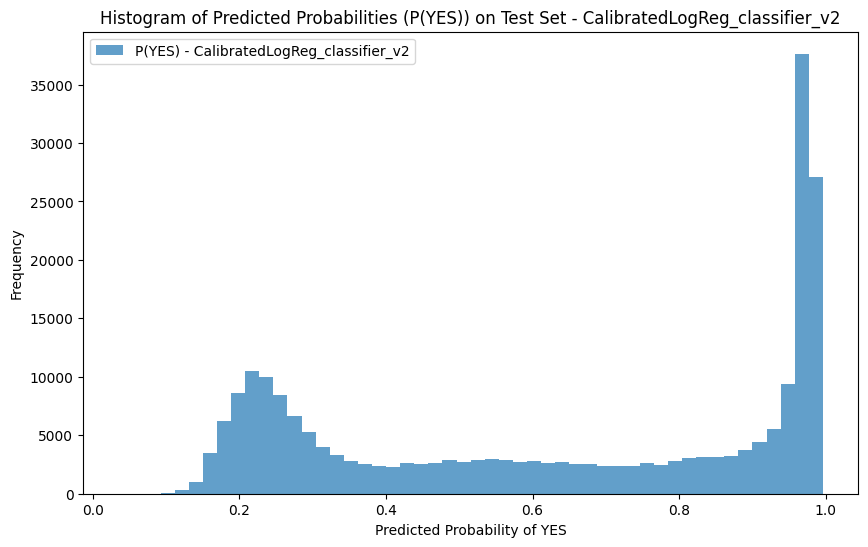

2025-05-22 02:38:19,979 - INFO - model_training_logreg_20250522_023756.<module>:79 - Description of P(YES) for CalibratedLogReg_classifier_v2 on test set:
count    231444.000000
mean          0.636374
std           0.310316
min           0.034777
25%           0.292754
50%           0.685825
75%           0.964214
max           0.996122
2025-05-22 02:38:19,979 - INFO - model_training_logreg_20250522_023756.<module>:81 - 
--- Confusion Matrix (Test Set) - CalibratedLogReg_classifier_v2 ---
2025-05-22 02:38:19,983 - INFO - model_training_logreg_20250522_023756.<module>:83 - 
[[ 82424  29906]
 [  6897 112217]]
2025-05-22 02:38:19,983 - INFO - model_training_logreg_20250522_023756.<module>:86 -   True Negatives (TN):  82424
2025-05-22 02:38:19,984 - INFO - model_training_logreg_20250522_023756.<module>:87 -   False Positives (FP): 29906 (Type I Error)
2025-05-22 02:38:19,984 - INFO - model_training_logreg_20250522_023756.<module>:88 -   False Negatives (FN): 6897 (Type II Error)
2025-05-22

Top Feature Coefficients (by absolute value):
                           feature  coefficient
21              distance_to_strike     1.470219
23     time_until_market_close_min     1.356756
0              btc_price_t_minus_1     0.998454
11                     btc_sma_50m    -0.703486
30                kalshi_mid_price     0.691180
27                  kalshi_yes_bid     0.619175
16            btc_price_vs_ema_26m     0.618478
7                      btc_sma_10m     0.601150
17                     btc_ema_50m    -0.576915
13                     btc_ema_12m     0.539852
28                  kalshi_yes_ask     0.433050
25                 day_of_week_utc    -0.351411
18            btc_price_vs_ema_50m    -0.336670
32  kalshi_open_interest_t_minus_1    -0.280804
10            btc_price_vs_sma_30m    -0.184715
22     distance_to_strike_norm_atr     0.179902
34              kalshi_mid_vol_10m     0.177547
9                      btc_sma_30m    -0.135091
29                   kalshi_spread    -0.1

In [3]:
# Cell 3: Logistic Regression Model Training and Evaluation

if 'X_train_scaled_df' not in globals() or X_train_scaled_df.empty:
    logger.error("Scaled training data (X_train_scaled_df) not found or is empty. Please ensure Cell 2 ran successfully.")
else:
    logger.info("--- Starting Logistic Regression Model Training (with Calibration) ---")

    # --- 1. Initialize Base LogisticRegression Model ---
    # Standard parameters for Logistic Regression. L2 penalty is common.
    # 'liblinear' solver is good for smaller datasets, 'saga' or 'lbfgs' for larger.
    # saga supports elasticnet, l1, l2. lbfgs supports l2 or none.
    base_logreg_model = LogisticRegression(
        solver='liblinear', # Good default, handles L1 and L2
        penalty='l2',       # L2 regularization by default
        C=1.0,              # Inverse of regularization strength; smaller values specify stronger regularization.
        class_weight='balanced', # Adjusts weights inversely proportional to class frequencies
        random_state=42,
        max_iter=1000       # Increased max_iter for convergence
    )
    
    # Model name for artifacts
    model_name = "CalibratedLogReg_classifier_v2" # Using V2 features

    # --- 2. Initialize and Train CalibratedClassifierCV ---
    # We'll calibrate the Logistic Regression model as well.
    logger.info(f"Training {model_name} (Calibrated Logistic Regression with sigmoid) on {X_train_scaled_df.shape[0]} samples...")
    
    calibrated_logreg_model = CalibratedClassifierCV(
        base_logreg_model, # Pass the configured Logistic Regression
        method='sigmoid',  # Platt scaling
        cv=3               # Number of folds for calibration (3 or 5 is common)
    )
    
    logger.info(f"Model parameters for CalibratedClassifierCV: {calibrated_logreg_model.get_params()}")
    
    if 'y_train' not in globals() or y_train.empty:
        logger.error("y_train (binary target) is not available. Cannot train calibrated model.")
    else:
        try:
            calibrated_logreg_model.fit(X_train_scaled_df, y_train) # Fit on scaled data
            logger.info(f"{model_name} model training complete.")

            # --- 3. Make Predictions on the Test Set ---
            if X_test_scaled_df.empty:
                logger.warning("Test set (X_test_scaled_df) is empty. Skipping predictions and evaluation.")
            else:
                logger.info(f"Making predictions with {model_name} on the test set ({X_test_scaled_df.shape[0]} samples)...\n")
                y_pred_test_class = calibrated_logreg_model.predict(X_test_scaled_df)
                y_pred_test_proba = calibrated_logreg_model.predict_proba(X_test_scaled_df)[:, 1]

                # --- 4. Evaluate Model Performance ---
                if 'y_test' not in globals() or y_test.empty:
                    logger.error("y_test (binary target) is not available. Cannot evaluate model.")
                else:
                    accuracy = accuracy_score(y_test, y_pred_test_class)
                    precision = precision_score(y_test, y_pred_test_class, zero_division=0)
                    recall = recall_score(y_test, y_pred_test_class, zero_division=0)
                    f1 = f1_score(y_test, y_pred_test_class, zero_division=0)
                    try: roc_auc = roc_auc_score(y_test, y_pred_test_proba)
                    except ValueError as e: logger.warning(f"Could not calculate ROC AUC: {e}"); roc_auc = np.nan
                    logloss = log_loss(y_test, y_pred_test_proba)

                    logger.info(f"--- {model_name} Evaluation Metrics (Test Set) ---")
                    logger.info(f"  Accuracy:          {accuracy:.4f}")
                    logger.info(f"  Precision:         {precision:.4f}")
                    logger.info(f"  Recall (TPR):      {recall:.4f}")
                    logger.info(f"  F1-Score:          {f1:.4f}")
                    logger.info(f"  ROC AUC:           {roc_auc:.4f}")
                    logger.info(f"  Log Loss:          {logloss:.4f}")

                    import matplotlib.pyplot as plt
                    plt.figure(figsize=(10,6))
                    plt.hist(y_pred_test_proba, bins=50, alpha=0.7, label=f'P(YES) - {model_name}')
                    plt.title(f'Histogram of Predicted Probabilities (P(YES)) on Test Set - {model_name}')
                    plt.xlabel('Predicted Probability of YES')
                    plt.ylabel('Frequency')
                    plt.legend()
                    plt.show()
                    logger.info(f"Description of P(YES) for {model_name} on test set:\n{pd.Series(y_pred_test_proba).describe().to_string()}")

                    logger.info(f"\n--- Confusion Matrix (Test Set) - {model_name} ---")
                    cm = confusion_matrix(y_test, y_pred_test_class)
                    logger.info(f"\n{cm}")
                    try:
                        tn, fp, fn, tp = cm.ravel()
                        logger.info(f"  True Negatives (TN):  {tn}")
                        logger.info(f"  False Positives (FP): {fp} (Type I Error)")
                        logger.info(f"  False Negatives (FN): {fn} (Type II Error)")
                        logger.info(f"  True Positives (TP):  {tp}")
                    except ValueError: logger.warning("Could not unpack full confusion matrix.")

                    # --- 5. Inspect Coefficients (for Logistic Regression) ---
                    # Coefficients are from the *base* logistic regression model within CalibratedClassifierCV.
                    # CalibratedClassifierCV fits multiple base models if cv > 1.
                    # We'll look at coefficients from the first calibrated estimator's base model.
                    logger.info(f"\n\n--- Coefficients (from base model of {model_name}) ---")
                    try:
                        # Access the base estimator from one of the calibrated classifiers
                        # (e.g., the first one, assuming they are similar)
                        if calibrated_logreg_model.calibrated_classifiers_ and \
                           hasattr(calibrated_logreg_model.calibrated_classifiers_[0].estimator, 'coef_'):
                            
                            base_estimator_for_coef = calibrated_logreg_model.calibrated_classifiers_[0].estimator
                            coefficients = base_estimator_for_coef.coef_[0] # Coef_ is 2D for binary, get first row

                            if 'feature_columns' in globals() and len(feature_columns) == len(coefficients):
                                feature_names_for_coef = feature_columns
                            else: # Fallback if feature_columns global isn't perfect match
                                feature_names_for_coef = [f"feature_{i}" for i in range(len(coefficients))]
                                logger.warning("Using generic feature names for coefficients as 'feature_columns' global mismatch.")

                            coef_df = pd.DataFrame({'feature': feature_names_for_coef, 'coefficient': coefficients})
                            coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
                            coef_df.sort_values(by='abs_coefficient', ascending=False, inplace=True)
                            
                            print("Top Feature Coefficients (by absolute value):")
                            print(coef_df[['feature', 'coefficient']].head(30).to_string())
                        else:
                            logger.warning(f"Could not retrieve coefficients from the base LogReg model for {model_name}.")
                    except Exception as e_coef:
                        logger.error(f"Error retrieving coefficients: {e_coef}")


                    # --- 6. Save the Trained CALIBRATED Model ---
                    model_path = MODEL_OUTPUT_DIR / f"{model_name}.joblib"
                    joblib.dump(calibrated_logreg_model, model_path)
                    logger.info(f"Trained {model_name} model saved to: {model_path}")

                    model_hyperparams = calibrated_logreg_model.get_params(deep=True)
                    params_path = MODEL_OUTPUT_DIR / f"{model_name}_hyperparams.json"
                    with open(params_path, 'w') as f:
                        serializable_params = {}
                        for k_param, v_param in model_hyperparams.items():
                            if isinstance(v_param, np.ndarray): serializable_params[k_param] = v_param.tolist()
                            elif isinstance(v_param, (np.bool_, np.integer, np.floating)): serializable_params[k_param] = v_param.item()
                            elif isinstance(v_param, (BaseException)): serializable_params[k_param] = str(v_param) # e.g. for base_estimator
                            else: serializable_params[k_param] = v_param
                        json.dump(serializable_params, f, indent=4, default=lambda o: '<not serializable>')
                    logger.info(f"{model_name} hyperparameters saved to: {params_path}")
        except Exception as e:
            logger.critical(f"An error occurred during {model_name} model training or evaluation: {e}", exc_info=True)